## Feature set 2

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
import librosa
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split
import time
from keras.callbacks import EarlyStopping

from keras import Sequential
from keras.layers import Dense,Conv2D,MaxPooling2D,Flatten,Dropout,merge,Activation

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

Using TensorFlow backend.


#### Extracting data from csv files into numpy arrays

In [2]:
#extracting data from csv files into numpy arrays
from numpy import genfromtxt
files_data=np.array(['fold_data_1.csv','fold_data_2.csv','fold_data_3.csv','fold_data_4.csv','fold_data_5.csv',
                'fold_data_6.csv','fold_data_7.csv','fold_data_8.csv','fold_data_9.csv','fold_data_10.csv'])
X_folds= np.array([genfromtxt(file,delimiter=',') for file in files_data])

files_label=(['fold_labels_1.csv','fold_labels_2.csv','fold_labels_3.csv','fold_labels_4.csv','fold_labels_5.csv',
                'fold_labels_6.csv','fold_labels_7.csv','fold_labels_8.csv','fold_labels_9.csv','fold_labels_10.csv'])
Y_folds= np.array([genfromtxt(file,delimiter=',') for file in files_label])

In [3]:
def data_processor_cnn(X_fold,Y_fold):
    X_fold_processor_cnn = [0]*10
    Y_fold_processor_cnn = [0]*10
    Y_fold_processor_cnn=([to_categorical(Y_fold, num_classes=10) for Y_fold in Y_fold])
    for i in range(0, len(X_fold)):
        X_fold_processor_cnn[i]=np.reshape(X_fold[i],(X_fold[i].shape[0], 32, 8, 1))
    return X_fold_processor_cnn,Y_fold_processor_cnn

In [4]:
def data_processor_basic_nn(X_fold,Y_fold):
    X_fold_basic_nn = [0]*10
    Y_fold_basic_nn = [0]*10
    for i in range(0, len(Y_fold)):
        Y_fold_basic_nn[i]=np.reshape(Y_fold[i],(Y_fold[i].shape[0], 1))
    for i in range(0, len(X_fold)):
        X_fold_basic_nn[i]=np.reshape(X_fold[i],(X_fold[i].shape[0], 32, 8))
    return X_fold_basic_nn,Y_fold_basic_nn

In [5]:
def data_processor_log_reg(X_fold,Y_fold):
    X_fold_log_reg = [0]*10
    Y_fold_log_reg = [0]*10
    for i in range(0, len(Y_fold)):
        Y_fold_log_reg[i]=np.reshape(Y_fold[i],(Y_fold[i].shape[0], 1))
    for i in range(0, len(X_fold)):
        X_fold_log_reg[i]=np.reshape(X_fold[i],(X_fold[i].shape[0], 256))
    return X_fold_log_reg,Y_fold_log_reg

In [6]:
Data_cnn=data_processor_cnn(X_folds,Y_folds)
X_folds_10=Data_cnn[0]
Y_folds_10=Data_cnn[1]

In [7]:
Data_nn=data_processor_basic_nn(X_folds,Y_folds)
X_folds_1=Data_nn[0]
Y_folds_1=Data_nn[1]

In [8]:
Data_Linear=data_processor_log_reg(X_folds,Y_folds)
X_folds_2=Data_Linear[0]
Y_folds_2=Data_Linear[1]

##### shapes of data

In [9]:
for i in range((10)):
    print("X_data",i+1,"=",np.shape(X_folds_10[i]))
    print("Y_data",i+1,"=",np.shape(Y_folds_10[i]))
    
for i in range((10)):
    print("X_data",i+1,"=",np.shape(X_folds_1[i]))
    print("Y_data",i+1,"=",np.shape(Y_folds_1[i]))

X_data 1 = (873, 32, 8, 1)
Y_data 1 = (873, 10)
X_data 2 = (888, 32, 8, 1)
Y_data 2 = (888, 10)
X_data 3 = (925, 32, 8, 1)
Y_data 3 = (925, 10)
X_data 4 = (990, 32, 8, 1)
Y_data 4 = (990, 10)
X_data 5 = (936, 32, 8, 1)
Y_data 5 = (936, 10)
X_data 6 = (823, 32, 8, 1)
Y_data 6 = (823, 10)
X_data 7 = (838, 32, 8, 1)
Y_data 7 = (838, 10)
X_data 8 = (806, 32, 8, 1)
Y_data 8 = (806, 10)
X_data 9 = (816, 32, 8, 1)
Y_data 9 = (816, 10)
X_data 10 = (837, 32, 8, 1)
Y_data 10 = (837, 10)
X_data 1 = (873, 32, 8)
Y_data 1 = (873, 1)
X_data 2 = (888, 32, 8)
Y_data 2 = (888, 1)
X_data 3 = (925, 32, 8)
Y_data 3 = (925, 1)
X_data 4 = (990, 32, 8)
Y_data 4 = (990, 1)
X_data 5 = (936, 32, 8)
Y_data 5 = (936, 1)
X_data 6 = (823, 32, 8)
Y_data 6 = (823, 1)
X_data 7 = (838, 32, 8)
Y_data 7 = (838, 1)
X_data 8 = (806, 32, 8)
Y_data 8 = (806, 1)
X_data 9 = (816, 32, 8)
Y_data 9 = (816, 1)
X_data 10 = (837, 32, 8)
Y_data 10 = (837, 1)


# Defining Functions
## Simple nn function

In [10]:

def Model_run_nn(model_history,model,X_folds,Y_folds,Accuracy_array,accuracy_total,end_array,Epoch_array_accuracy,Loss_array,
             Fold_accuracy,Val_accuracy_array,Val_Loss_array, Confusion_Matrix_array, 
             Metrics_f1, Metrics_precision, Metrics_recall, Metrics_accuracy):
   
    fold=0
    for i in range(10):
        start = time.time()
        fold+=1
        print(f"\nFold #{fold}\n- - - - - - - - - - - - - - - - - - - -")

        x_train = np.vstack([X_folds[j] for j in range(0, len(Y_folds)) if i!=j])
        y_train = np.vstack([Y_folds[j] for j in range(0, len(Y_folds)) if i!=j])
        x_test = np.vstack([X_folds[j] for j in range(0, len(Y_folds)) if i==j])
        y_test = np.vstack([Y_folds[j] for j in range(0, len(Y_folds)) if i==j])
        print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)
    
        model_history = model.fit(x_train,y_train,batch_size=Batch_size,epochs=Epoch_number,validation_data=(x_test,y_test)
                                  ,verbose=0)
        
        model_evaluation = model.evaluate(x_test, y_test, verbose = 0)
        score=model_evaluation[1]
        accuracy_score.append(score)
        
        # Generate confusion matrix
        y_pred = model.predict_classes(x_test)
        cm = sklearn.metrics.confusion_matrix(y_test, y_pred)
        Confusion_Matrix_array.append(cm)
        
        # metrics
        f1 = sklearn.metrics.f1_score(y_test, y_pred, average='weighted')
        precision = sklearn.metrics.precision_score(y_test, y_pred, average='weighted')
        recall = sklearn.metrics.recall_score(y_test, y_pred, average='weighted')
        accuracy = sklearn.metrics.accuracy_score(y_test, y_pred)
        
        Metrics_f1.append(f1)
        Metrics_precision.append(precision)
        Metrics_recall.append(recall)
        Metrics_accuracy.append(accuracy)
        
        accuracy=model_history.history['accuracy']
        accuracy_avg=np.mean(accuracy)
        
        Fold_accuracy.append(accuracy_avg)
        print(f"Accuracy of Fold {fold} is {accuracy_avg}")
        end = time.time()
        print("Time to train Fold", fold,":",round(((end)- (start)),4),"seconds.")
        end_array.append(round(((end)- (start)),4))
        
    
        Epoch_array=model_history.history['accuracy']
        Epoch_array_accuracy.append(Epoch_array)
        loss=model_history.history['loss']
        Loss_array.append(loss)
    
        Epoch_val_array=model_history.history['val_accuracy']
        Val_accuracy_array.append(Epoch_val_array)
    
        loss_val=model_history.history['val_loss']
        Val_Loss_array.append(loss_val)
    
    Avg_Accuracy=np.mean(Fold_accuracy)       
    Time=sum(end_array)
    print("\n - - - - - - - - - - - - - - -\nThe average accuracy of the model:",(Avg_Accuracy))
    print("The time taken to run model:",Time)
    return Avg_Accuracy,Time

In [11]:
def Model_run_nn_es(model_history,model,X_folds,Y_folds,Accuracy_array,accuracy_total,end_array,Epoch_array_accuracy,Loss_array,
             Fold_accuracy,Val_accuracy_array,Val_Loss_array, Confusion_Matrix_array,
             Metrics_f1, Metrics_precision, Metrics_recall, Metrics_accuracy):
    
    for i in range(0, len(X_folds)):
        X_folds[i]=np.reshape(X_folds[i],(X_folds[i].shape[0], 32, 8, 1))
    fold=0
    for i in range(10):
        start = time.time()
        fold+=1
        print(f"\nFold #{fold}\n- - - - - - - - - - - - - - - - - - - -")

        x_train = np.vstack([X_folds[j] for j in range(0, len(Y_folds)) if i!=j])
        y_train = np.vstack([Y_folds[j] for j in range(0, len(Y_folds)) if i!=j])
        x_test = np.vstack([X_folds[j] for j in range(0, len(Y_folds)) if i==j])
        y_test = np.vstack([Y_folds[j] for j in range(0, len(Y_folds)) if i==j])
        print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)
    
        model_history = model.fit(x_train,y_train,epochs=Epoch_number,validation_data=(x_test,y_test)
                                  ,verbose=0, callbacks=[early_stopping_cb])
        
        model_evaluation = model.evaluate(x_test, y_test, verbose = 0)
        score=model_evaluation[1]
        accuracy_score.append(score)
        
        # Generate confusion matrix
        y_pred = model.predict_classes(x_test)
        # Reverse categorical y_test (used in CNN)
        y_test_a = np.argmax(y_test, axis=1)
#         print(y_test_a)
        cm = sklearn.metrics.confusion_matrix(y_test_a, y_pred)
        Confusion_Matrix_array.append(cm)
        
        # metrics
        f1 = sklearn.metrics.f1_score(y_test_a, y_pred, average='weighted')
        precision = sklearn.metrics.precision_score(y_test_a, y_pred, average='weighted')
        recall = sklearn.metrics.recall_score(y_test_a, y_pred, average='weighted')
        accuracy = sklearn.metrics.accuracy_score(y_test_a, y_pred)
        
        Metrics_f1.append(f1)
        Metrics_precision.append(precision)
        Metrics_recall.append(recall)
        Metrics_accuracy.append(accuracy)
        
        accuracy=model_history.history['accuracy']
        accuracy_avg=np.mean(accuracy)
        
        Fold_accuracy.append(accuracy_avg)
        print(f"Accuracy of Fold {fold} is {accuracy_avg}")
        end = time.time()
        print("Time to train Fold", fold,":",round(((end)- (start)),4),"seconds.")
        end_array.append(round(((end)- (start)),4))
        
    
        Epoch_array=model_history.history['accuracy']
        Epoch_array_accuracy.append(Epoch_array)
        loss=model_history.history['loss']
        Loss_array.append(loss)
    
        Epoch_val_array=model_history.history['val_accuracy']
        Val_accuracy_array.append(Epoch_val_array)
    
        loss_val=model_history.history['val_loss']
        Val_Loss_array.append(loss_val)
    
    Avg_Accuracy=np.mean(Fold_accuracy)       
    Time=sum(end_array)
    print("\n - - - - - - - - - - - - - - -\nThe average accuracy of the model:",(Avg_Accuracy))
    print("The time taken to run model:",Time)
    return Avg_Accuracy,Time

In [12]:
def Model_run_nn_es_NO_EARLY_STOPPING(model_history,model,X_folds,Y_folds,Accuracy_array,accuracy_total,end_array,Epoch_array_accuracy,Loss_array,
             Fold_accuracy,Val_accuracy_array,Val_Loss_array, Confusion_Matrix_array,
             Metrics_f1, Metrics_precision, Metrics_recall, Metrics_accuracy):
    
    for i in range(0, len(X_folds)):
        X_folds[i]=np.reshape(X_folds[i],(X_folds[i].shape[0], 32, 8, 1))
    fold=0
    for i in range(10):
        start = time.time()
        fold+=1
        print(f"\nFold #{fold}\n- - - - - - - - - - - - - - - - - - - -")

        x_train = np.vstack([X_folds[j] for j in range(0, len(Y_folds)) if i!=j])
        y_train = np.vstack([Y_folds[j] for j in range(0, len(Y_folds)) if i!=j])
        x_test = np.vstack([X_folds[j] for j in range(0, len(Y_folds)) if i==j])
        y_test = np.vstack([Y_folds[j] for j in range(0, len(Y_folds)) if i==j])
        print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)
    
        model_history = model.fit(x_train,y_train,epochs=Epoch_number,validation_data=(x_test,y_test)
                                  ,verbose=0)
        
        model_evaluation = model.evaluate(x_test, y_test, verbose = 0)
        score=model_evaluation[1]
        accuracy_score.append(score)
        
        # Generate confusion matrix
        y_pred = model.predict_classes(x_test)
        # Reverse categorical y_test (used in CNN)
        y_test_a = np.argmax(y_test, axis=1)
#         print(y_test_a)
        cm = sklearn.metrics.confusion_matrix(y_test_a, y_pred)
        Confusion_Matrix_array.append(cm)
        
        # metrics
        f1 = sklearn.metrics.f1_score(y_test_a, y_pred, average='weighted')
        precision = sklearn.metrics.precision_score(y_test_a, y_pred, average='weighted')
        recall = sklearn.metrics.recall_score(y_test_a, y_pred, average='weighted')
        accuracy = sklearn.metrics.accuracy_score(y_test_a, y_pred)
        
        Metrics_f1.append(f1)
        Metrics_precision.append(precision)
        Metrics_recall.append(recall)
        Metrics_accuracy.append(accuracy)
        
        accuracy=model_history.history['accuracy']
        accuracy_avg=np.mean(accuracy)
        
        Fold_accuracy.append(accuracy_avg)
        print(f"Accuracy of Fold {fold} is {accuracy_avg}")
        end = time.time()
        print("Time to train Fold", fold,":",round(((end)- (start)),4),"seconds.")
        end_array.append(round(((end)- (start)),4))
        
    
        Epoch_array=model_history.history['accuracy']
        Epoch_array_accuracy.append(Epoch_array)
        loss=model_history.history['loss']
        Loss_array.append(loss)
    
        Epoch_val_array=model_history.history['val_accuracy']
        Val_accuracy_array.append(Epoch_val_array)
    
        loss_val=model_history.history['val_loss']
        Val_Loss_array.append(loss_val)
    
    Avg_Accuracy=np.mean(Fold_accuracy)       
    Time=sum(end_array)
    print("\n - - - - - - - - - - - - - - -\nThe average accuracy of the model:",(Avg_Accuracy))
    print("The time taken to run model:",Time)
    return Avg_Accuracy,Time

### Graph function

In [13]:
def Graph_func(Epoch_number,Epoch_array_accuracy,Val_accuracy_array,Loss_array,val_loss_array):
    %matplotlib inline
    
    fig,ax1 = plt.subplots(1, 1, constrained_layout=True, subplot_kw=dict())
    fig.suptitle(f"Accuracy of each Epoch for each Fold")
    ax1.set_xlabel("Epoch number")
    ax1.set_ylabel("Accuracy")
    ax1.grid()
    for i in range(10):
        ax1.plot(Epoch_array_accuracy[i],label=('Fold',i+1))
        ax1.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    
    fig,ax1 = plt.subplots(1, 1, constrained_layout=True, subplot_kw=dict())
    fig.suptitle(f"Accuracy of each Epoch for each Fold")
    ax1.set_xlabel("Epoch number")
    ax1.set_ylabel("Val Accuracy")
    ax1.grid()
    for i in range(10):
        ax1.plot(Val_accuracy_array[i],label=('Fold',i+1))
        ax1.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    
    fig1,ax2 = plt.subplots(1, 1, constrained_layout=True, subplot_kw=dict())
    fig1.suptitle(f"Loss of each Epoch for each Fold")
    ax2.set_xlabel("Epoch")
    ax2.set_ylabel("Loss")
    ax2.grid()
    for i in range(10):
        ax2.plot(Loss_array[i],label=('Fold',i+1))
        ax2.legend(loc='center left', bbox_to_anchor=(1, 0.5))    
    
    fig1,ax2 = plt.subplots(1, 1, constrained_layout=True, subplot_kw=dict())
    fig1.suptitle(f"Val Loss of each Epoch for each Fold")
    ax2.set_xlabel("Epoch")
    ax2.set_ylabel("Val Loss")
    ax2.grid()
    for i in range(10):
        ax2.plot(val_loss_array[i],label=('Fold',i+1))
        ax2.legend(loc='center left', bbox_to_anchor=(1, 0.5))   

### Table function

In [14]:
def table_maker(Fold_accuracy,end_array,Avg_Accuracy,Time):
    data= {'Fold': ['1','2','3','4','5','6','7','8','9','10'],
           'Accuracy': [Fold_accuracy[0],Fold_accuracy[1],Fold_accuracy[2],Fold_accuracy[3],Fold_accuracy[4],
                    Fold_accuracy[5],Fold_accuracy[6],Fold_accuracy[7],Fold_accuracy[8],Fold_accuracy[9]],
           'Time Taken' :[end_array[0],end_array[1],end_array[2],end_array[3],end_array[4],end_array[5],end_array[6],end_array[7],
                end_array[8],end_array[9]]}
    df = pd.DataFrame(data, columns = ['Fold', 'Accuracy','Time Taken'])
    data_avg={'Average Accuracy':[Avg_Accuracy],'Total Time':[Time]}
    df_avg=pd.DataFrame(data_avg,columns=['Average Accuracy','Total Time'])
    print (df)
    print ("\n",df_avg)

### Average graph function

In [15]:
def Graph_Avg_maker(Fold_accuracy,Avg_Accuracy):
    %matplotlib inline
    Fold_iteration=np.linspace(1,10,num=10)
    fig, ax1 = plt.subplots(1, 1, constrained_layout=True, subplot_kw=dict())
    ax1.plot(Fold_iteration,Fold_accuracy,"gx")
    ax1.axhline(y=Avg_Accuracy,label='Average Accuracy')
    fig.suptitle(f"Results for Batch size of {Batch_size}\n and Epoch number of {Epoch_number}\n for Feature set 3")
    ax1.set_xlabel("Fold iteration")
    ax1.set_ylabel("Accuracy")
    ax1.grid()
    ax1.legend(loc='center left', bbox_to_anchor=(1, 0.5))

### Confusion matrix function

In [16]:
import sklearn
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

def Confusion_matrix(x_test, y_test_a, model=None):

    if model == None:
        return 'Please pass a defined model to this function'
    
    # Create predictions
    try:
        y_test_pred = model.predict_classes(x_test)
    except:
        y_test_pred = model.predict(x_test)
    
    # Read file with the defined classes (should be available in every folder)
    classes = pd.read_csv("classes.csv")
    classes = classes['class'].tolist()
    
    # Create confusion matrix
    array = sklearn.metrics.confusion_matrix(y_test_a, y_test_pred)

    axis_labels = classes # labels for x and y axis

    # create seaborn heatmap with required labels
    plt.figure(figsize = (12, 10))
    sn.heatmap(array, annot=True, xticklabels=axis_labels, yticklabels=axis_labels)
    # fixing axis that are cut otherwise
    b, t = plt.ylim()
    b += 0.5
    t -= 0.5
    plt.ylim(b, t)
    plt.show()

In [17]:
def plot_confusion_matrix(cm):
    
    # Read file with the defined classes (should be available in every folder)
    classes = pd.read_csv("classes.csv")
    classes = classes['class'].tolist()
    
    # Read confusion matrix
    array = cm

    axis_labels = classes # labels for x and y axis

    # create seaborn heatmap with required labels
    plt.figure(figsize = (12, 10))
    sn.heatmap(array, annot=True, xticklabels=axis_labels, yticklabels=axis_labels)
    # fixing axis that are cut otherwise
    b, t = plt.ylim()
    b += 0.5
    t -= 0.5
    plt.ylim(b, t)
    plt.show()

In [18]:
def average_confusion_matrix(X):
    # Returns the average confusion matrix for the 10-fold cross-validation results
    avg_cm = (X[0]+X[1]+X[2]+X[3]+X[4]+X[5]+X[6]+X[7]+X[8]+X[9])
    return avg_cm

## Model 1

In [19]:
model=Sequential()
model.add(Flatten(input_shape=[32, 8]))
model.add(Dense(300, activation="relu"))   
model.add(Dense(100, activation="relu"))
model.add(Dense(10, activation="softmax"))
Model=model.compile(loss = "sparse_categorical_crossentropy", optimizer="adam", metrics = ["accuracy"])

In [20]:
Accuracy_array=[]
accuracy_total=0
end_array=[]
Epoch_array_accuracy=[]
Loss_array=[]
Fold_accuracy=[]
Val_accuracy_array=[]
Val_Loss_array_1=[]
Avg_Accuracy=[]
Time=[]
accuracy_score=[]
Confusion_Matrix_array = []
Metrics_f1 = []
Metrics_precision = []
Metrics_recall = []
Metrics_accuracy = []

Epoch_number=50
Batch_size=30

Model=Model_run_nn(Model,model,X_folds_1,Y_folds_1,Accuracy_array,
                   accuracy_total,end_array,Epoch_array_accuracy,Loss_array,
                   Fold_accuracy,Val_accuracy_array,Val_Loss_array_1, Confusion_Matrix_array,
                   Metrics_f1, Metrics_precision, Metrics_recall, Metrics_accuracy)

Avg_Accuracy=Model[0]
Time=Model[1]


Fold #1
- - - - - - - - - - - - - - - - - - - -
(7859, 32, 8) (7859, 1) (873, 32, 8) (873, 1)


C:\Users\tomna\Untitled Folder\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\tomna\Untitled Folder\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Accuracy of Fold 1 is 0.2708461582660675
Time to train Fold 1 : 51.8652 seconds.

Fold #2
- - - - - - - - - - - - - - - - - - - -
(7844, 32, 8) (7844, 1) (888, 32, 8) (888, 1)
Accuracy of Fold 2 is 0.21392402052879333
Time to train Fold 2 : 50.7984 seconds.

Fold #3
- - - - - - - - - - - - - - - - - - - -
(7807, 32, 8) (7807, 1) (925, 32, 8) (925, 1)
Accuracy of Fold 3 is 0.2010093480348587
Time to train Fold 3 : 50.8307 seconds.

Fold #4
- - - - - - - - - - - - - - - - - - - -
(7742, 32, 8) (7742, 1) (990, 32, 8) (990, 1)
Accuracy of Fold 4 is 0.19979849457740784
Time to train Fold 4 : 50.689 seconds.

Fold #5
- - - - - - - - - - - - - - - - - - - -
(7796, 32, 8) (7796, 1) (936, 32, 8) (936, 1)
Accuracy of Fold 5 is 0.24968956410884857
Time to train Fold 5 : 51.3339 seconds.

Fold #6
- - - - - - - - - - - - - - - - - - - -
(7909, 32, 8) (7909, 1) (823, 32, 8) (823, 1)
Accuracy of Fold 6 is 0.2107270061969757
Time to train Fold 6 : 44.1 seconds.

Fold #7
- - - - - - - - - - - - - - - -

In [21]:
print('Fold No, F-measure, Precision, Recall, Accuracy')
for i in range(10):
    print(f'{i+1}, {Metrics_f1[i]}, {Metrics_precision[i]}, {Metrics_recall[i]}, {Metrics_accuracy[i]}')
#     print(i + Metrics_f1 + ' , 'Metrics_precision + ' , 'Metrics_recall + ' , 'Metrics_accuracy)

Fold No, F-measure, Precision, Recall, Accuracy
1, 0.11224141665414131, 0.3479041262580736, 0.1764032073310424, 0.1764032073310424
2, 0.08046311049880805, 0.17152979674361815, 0.14977477477477477, 0.14977477477477477
3, 0.12563853140778808, 0.1842316263019287, 0.1881081081081081, 0.1881081081081081
4, 0.25357837633228103, 0.34151706757870376, 0.30808080808080807, 0.30808080808080807
5, 0.16493952808460877, 0.2773573864331474, 0.22542735042735043, 0.22542735042735043
6, 0.0983264503995937, 0.2272332975712884, 0.14702308626974483, 0.14702308626974483
7, 0.04656348868533715, 0.22675205966877104, 0.10859188544152745, 0.10859188544152745
8, 0.15187852614343827, 0.2188915543396823, 0.19975186104218362, 0.19975186104218362
9, 0.1822750829104519, 0.38138343636479516, 0.22916666666666666, 0.22916666666666666
10, 0.11501826353186252, 0.22424782732626192, 0.17204301075268819, 0.17204301075268819


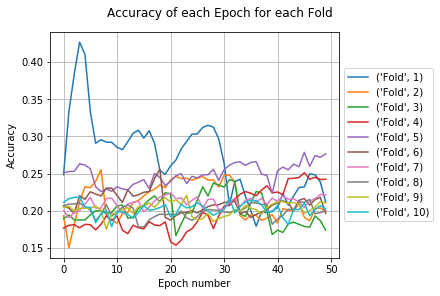

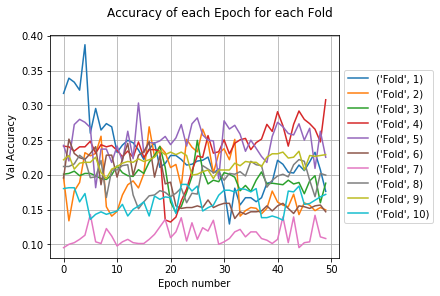

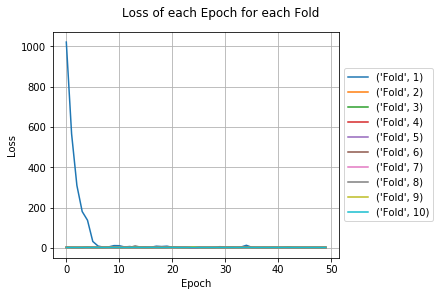

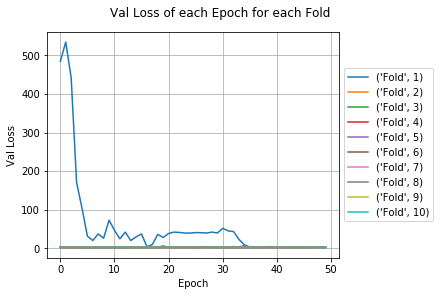

In [22]:
Graph_Epochs_model_1=Graph_func(Epoch_number,Epoch_array_accuracy,Val_accuracy_array,Loss_array,Val_Loss_array_1)

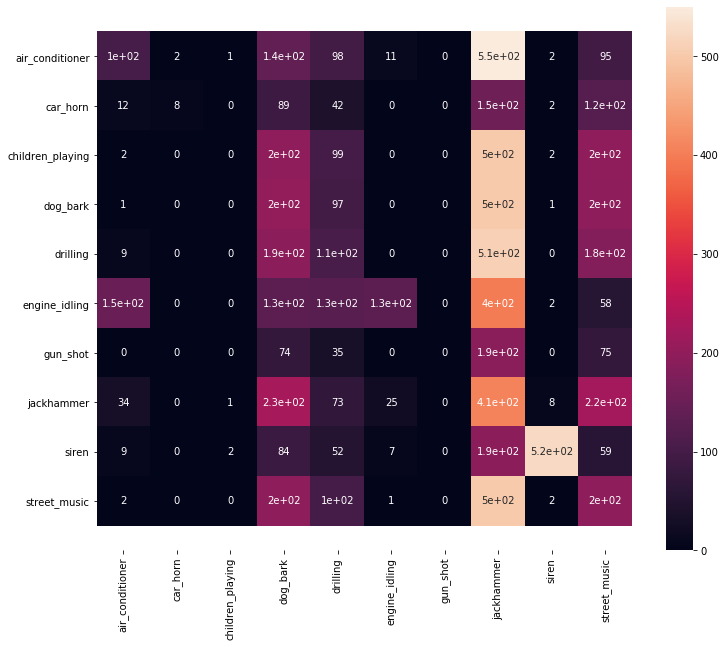

In [23]:
avg_cm = average_confusion_matrix(Confusion_Matrix_array)
plot_confusion_matrix(avg_cm)

In [24]:
Table_model_1=table_maker(Fold_accuracy,end_array,Avg_Accuracy,Time)

  Fold  Accuracy  Time Taken
0    1  0.270846     51.8652
1    2  0.213924     50.7984
2    3  0.201009     50.8307
3    4  0.199798     50.6890
4    5  0.249690     51.3339
5    6  0.210727     44.1000
6    7  0.211140     42.2693
7    8  0.199314     45.0367
8    9  0.202789     47.2738
9   10  0.202267     47.2986

    Average Accuracy  Total Time
0           0.21615    481.4956


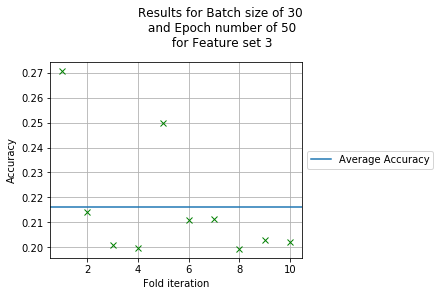

In [25]:
Graph_Avg_model_1=Graph_Avg_maker(Fold_accuracy,Avg_Accuracy)

### Model 1 no cross validation

In [26]:
for i in range(0, len(X_folds)):
    X_folds[i]=np.reshape(X_folds[i],(X_folds[i].shape[0], 32, 8))

X_train = np.vstack([X_folds[j] for j in range(0, len(Y_folds)-1)])
y_train = np.vstack([Y_folds_1[j] for j in range(0, len(Y_folds_1)-1)])
X_test = X_folds[9]
y_test = Y_folds[9]

Epoch_number=30

#compile model using accuracy to measure model performance
#model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
#train the model
cnn_model_history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=Epoch_number)
score_model_1_no_cross=model.evaluate(X_test, y_test)
accuracy_model_1_no_cross = score_model_1_no_cross[1]
print(f"\nAccuracy of model 1 with no cross validation: {round(accuracy_model_1_no_cross,3)}")

Train on 7895 samples, validate on 837 samples
Epoch 1/30
7895/7895 [==============================] - ETA: 1s - loss: 1.8733 - accuracy: 0.31 - ETA: 1s - loss: 1.9104 - accuracy: 0.25 - ETA: 0s - loss: 1.9679 - accuracy: 0.23 - ETA: 0s - loss: 1.9886 - accuracy: 0.21 - ETA: 0s - loss: 1.9897 - accuracy: 0.21 - ETA: 0s - loss: 1.9990 - accuracy: 0.21 - ETA: 0s - loss: 1.9974 - accuracy: 0.21 - ETA: 0s - loss: 2.0016 - accuracy: 0.21 - ETA: 0s - loss: 2.0348 - accuracy: 0.20 - ETA: 0s - loss: 2.0392 - accuracy: 0.20 - ETA: 0s - loss: 2.0519 - accuracy: 0.20 - ETA: 0s - loss: 2.0580 - accuracy: 0.20 - ETA: 0s - loss: 2.0633 - accuracy: 0.19 - ETA: 0s - loss: 2.0644 - accuracy: 0.19 - ETA: 0s - loss: 2.0671 - accuracy: 0.19 - ETA: 0s - loss: 2.0655 - accuracy: 0.19 - ETA: 0s - loss: 2.0661 - accuracy: 0.19 - ETA: 0s - loss: 2.0612 - accuracy: 0.19 - ETA: 0s - loss: 2.0578 - accuracy: 0.19 - ETA: 0s - loss: 2.0560 - accuracy: 0.19 - ETA: 0s - loss: 2.0539 - accuracy: 0.19 - 1s 146us/step -

## Model 2

In [27]:
#adding layers and forming the model_1
#forming model_1
model_2=Sequential()
early_stopping_cb = EarlyStopping(patience=16, restore_best_weights=True)

    #add model layers
model_2.add(Conv2D(64, kernel_size=3, activation='relu', input_shape=(32,8,1)))
model_2.add(Conv2D(32, kernel_size=3, activation='relu'))
model_2.add(Flatten())
model_2.add(Dense(10, activation='softmax'))
    #compile model using accuracy to measure model performance
Model_2=model_2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [28]:
Accuracy_array_2=[]
accuracy_total_2=0
end_array_2=[]

Epoch_array_accuracy_2=[]
Loss_array_2=[]
Fold_accuracy_2=[]

Val_accuracy_array_2=[]
Val_Loss_array_2=[]

Avg_Accuracy_2=[]
Time_2=[]

accuracy_score=[]
Epoch_number=50
Batch_size=30

Confusion_Matrix_array = []
Metrics_f1 = []
Metrics_precision = []
Metrics_recall = []
Metrics_accuracy = []

Model_2=Model_run_nn_es(Model_2,model_2,X_folds_10,Y_folds_10,Accuracy_array_2,
                     accuracy_total_2,end_array_2,Epoch_array_accuracy_2,Loss_array_2,
                     Fold_accuracy_2,Val_accuracy_array_2,Val_Loss_array_2, Confusion_Matrix_array,
                     Metrics_f1, Metrics_precision, Metrics_recall, Metrics_accuracy)
Avg_Accuracy_2=Model_2[0]
Time_2=Model_2[1]


Fold #1
- - - - - - - - - - - - - - - - - - - -
(7859, 32, 8, 1) (7859, 10) (873, 32, 8, 1) (873, 10)
Accuracy of Fold 1 is 0.7979829907417297
Time to train Fold 1 : 101.941 seconds.

Fold #2
- - - - - - - - - - - - - - - - - - - -
(7844, 32, 8, 1) (7844, 10) (888, 32, 8, 1) (888, 10)
Accuracy of Fold 2 is 0.8764165043830872
Time to train Fold 2 : 78.9118 seconds.

Fold #3
- - - - - - - - - - - - - - - - - - - -
(7807, 32, 8, 1) (7807, 10) (925, 32, 8, 1) (925, 10)
Accuracy of Fold 3 is 0.8940091133117676
Time to train Fold 3 : 72.9124 seconds.

Fold #4
- - - - - - - - - - - - - - - - - - - -
(7742, 32, 8, 1) (7742, 10) (990, 32, 8, 1) (990, 10)
Accuracy of Fold 4 is 0.9077377915382385
Time to train Fold 4 : 74.8714 seconds.

Fold #5
- - - - - - - - - - - - - - - - - - - -
(7796, 32, 8, 1) (7796, 10) (936, 32, 8, 1) (936, 10)
Accuracy of Fold 5 is 0.916609525680542
Time to train Fold 5 : 80.148 seconds.

Fold #6
- - - - - - - - - - - - - - - - - - - -
(7909, 32, 8, 1) (7909, 10) (823,

In [29]:
print('Fold No, F-measure, Precision, Recall, Accuracy')
for i in range(10):
    print(f'{i}, {Metrics_f1[i]}, {Metrics_precision[i]}, {Metrics_recall[i]}, {Metrics_accuracy[i]}')
#     print(i + Metrics_f1 + ' , 'Metrics_precision + ' , 'Metrics_recall + ' , 'Metrics_accuracy)

Fold No, F-measure, Precision, Recall, Accuracy
0, 0.5273805686530701, 0.5465106620131659, 0.5360824742268041, 0.5360824742268041
1, 0.7484259208483632, 0.7617358423063831, 0.7533783783783784, 0.7533783783783784
2, 0.7108312364892584, 0.7203034128603379, 0.7113513513513513, 0.7113513513513513
3, 0.7369612580503602, 0.7483258644702752, 0.7353535353535353, 0.7353535353535353
4, 0.7812654658670743, 0.796558417160159, 0.7799145299145299, 0.7799145299145299
5, 0.7954336090342358, 0.8086882869781049, 0.7934386391251519, 0.7934386391251519
6, 0.8885636507473845, 0.8971049888144204, 0.8878281622911695, 0.8878281622911695
7, 0.7921814559582431, 0.8057146800354023, 0.794044665012407, 0.794044665012407
8, 0.859965582810679, 0.8667500218186598, 0.8615196078431373, 0.8615196078431373
9, 0.8708622628276523, 0.8750710733913999, 0.8709677419354839, 0.8709677419354839


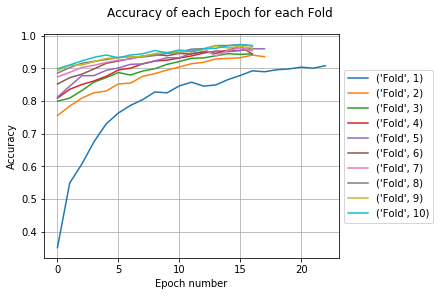

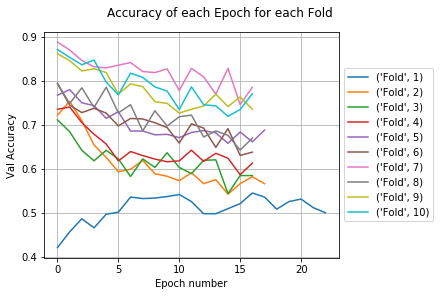

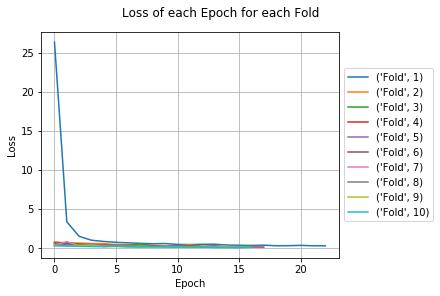

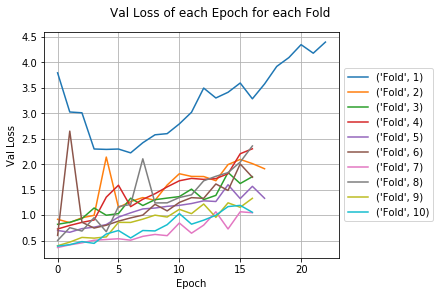

In [30]:
Graph_Epochs_model_2=Graph_func(Epoch_number,Epoch_array_accuracy_2,Val_accuracy_array_2,Loss_array_2,Val_Loss_array_2)

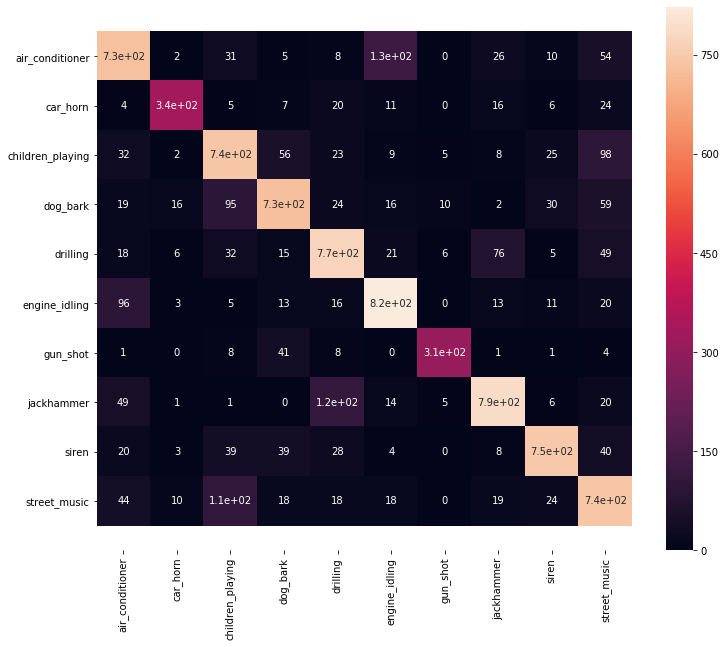

In [31]:
avg_cm = average_confusion_matrix(Confusion_Matrix_array)
plot_confusion_matrix(avg_cm)

In [32]:
Table_model_2=table_maker(Fold_accuracy_2,end_array_2,Avg_Accuracy_2,Time_2)

  Fold  Accuracy  Time Taken
0    1  0.797983    101.9410
1    2  0.876417     78.9118
2    3  0.894009     72.9124
3    4  0.907738     74.8714
4    5  0.916610     80.1480
5    6  0.926331     74.6739
6    7  0.932272     86.8980
7    8  0.940909     98.5233
8    9  0.940433     97.7785
9   10  0.945409     97.1052

    Average Accuracy  Total Time
0          0.907811    863.7635


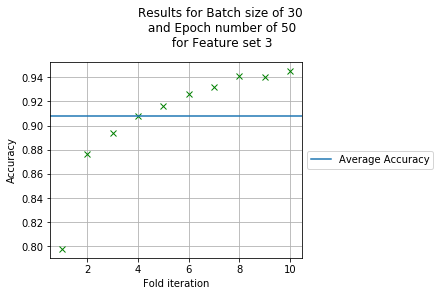

In [33]:
Graph_Avg_model_2=Graph_Avg_maker(Fold_accuracy_2,Avg_Accuracy_2)

### Model 2 no cross validation

In [34]:
for i in range(0, len(X_folds)):
    X_folds[i]=np.reshape(X_folds[i],(X_folds[i].shape[0], 32, 8,1))

Epoch_number=30
X_train = np.vstack([X_folds_10[j] for j in range(0, len(Y_folds_10)-1)])
y_train = np.vstack([Y_folds_10[j] for j in range(0, len(Y_folds_10)-1)])
X_test = X_folds_10[9]
y_test = Y_folds_10[9]

cnn_model_2_history = model_2.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=Epoch_number)
score_model_2_no_cross=model_2.evaluate(X_test, y_test)
accuracy_model_2_no_cross = score_model_2_no_cross[1]
print(f"\nAccuracy of model 2 with no cross validation: {round(accuracy_model_2_no_cross,3)}")

Train on 7895 samples, validate on 837 samples
Epoch 1/30
7895/7895 [==============================] - ETA: 6s - loss: 0.5043 - accuracy: 0.84 - ETA: 6s - loss: 0.3316 - accuracy: 0.89 - ETA: 7s - loss: 0.3168 - accuracy: 0.88 - ETA: 7s - loss: 0.2753 - accuracy: 0.90 - ETA: 7s - loss: 0.2589 - accuracy: 0.90 - ETA: 7s - loss: 0.2590 - accuracy: 0.90 - ETA: 7s - loss: 0.2635 - accuracy: 0.90 - ETA: 7s - loss: 0.2662 - accuracy: 0.90 - ETA: 7s - loss: 0.2698 - accuracy: 0.90 - ETA: 7s - loss: 0.2628 - accuracy: 0.90 - ETA: 7s - loss: 0.2603 - accuracy: 0.90 - ETA: 7s - loss: 0.2578 - accuracy: 0.91 - ETA: 7s - loss: 0.2466 - accuracy: 0.91 - ETA: 6s - loss: 0.2506 - accuracy: 0.91 - ETA: 6s - loss: 0.2670 - accuracy: 0.91 - ETA: 6s - loss: 0.2710 - accuracy: 0.91 - ETA: 6s - loss: 0.2676 - accuracy: 0.91 - ETA: 6s - loss: 0.2595 - accuracy: 0.91 - ETA: 6s - loss: 0.2634 - accuracy: 0.91 - ETA: 6s - loss: 0.2684 - accuracy: 0.91 - ETA: 6s - loss: 0.2639 - accuracy: 0.91 - ETA: 6s - loss:

## Model 3

In [35]:
model_3=Sequential()
early_stopping_cb = EarlyStopping(patience=17, restore_best_weights=True)

model_3.add(Conv2D(32,kernel_size=5,strides=1,padding="Same",activation="relu",input_shape=(32,8,1)))
model_3.add(MaxPooling2D(padding="same"))

model_3.add(Conv2D(64,kernel_size=5,strides=1,padding="same",activation="relu"))
model_3.add(MaxPooling2D(padding="same"))
model_3.add(Dropout(0.2))

model_3.add(Flatten())

model_3.add(Dense(128,activation="relu"))
model_3.add(Dropout(0.2))

model_3.add(Dense(10,activation="softmax"))

    #compiling
Model_3=model_3.compile(optimizer="adam",loss="categorical_crossentropy",metrics=["accuracy"])

In [36]:
Accuracy_array_3=[]
accuracy_total_3=0
end_array_3=[]

Epoch_array_accuracy_3=[]
Loss_array_3=[]
Fold_accuracy_3=[]

Val_accuracy_array_3=[]
Val_Loss_array_3=[]

Avg_Accuracy_3=[]
Time_3=[]

accuracy_score=[]
Epoch_number=50
Batch_size=30

Confusion_Matrix_array = []
Metrics_f1 = []
Metrics_precision = []
Metrics_recall = []
Metrics_accuracy = []

Model_3=Model_run_nn_es(Model_3,model_3,X_folds_10,Y_folds_10,Accuracy_array_3,
                     accuracy_total_3,end_array_3,Epoch_array_accuracy_3,Loss_array_3,
                     Fold_accuracy_3,Val_accuracy_array_3,Val_Loss_array_3, Confusion_Matrix_array,
                     Metrics_f1, Metrics_precision, Metrics_recall, Metrics_accuracy)
Avg_Accuracy_3=Model_3[0]
Time_3=Model_3[1]


Fold #1
- - - - - - - - - - - - - - - - - - - -
(7859, 32, 8, 1) (7859, 10) (873, 32, 8, 1) (873, 10)


C:\Users\tomna\Untitled Folder\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\tomna\Untitled Folder\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Accuracy of Fold 1 is 0.11223669350147247
Time to train Fold 1 : 323.023 seconds.

Fold #2
- - - - - - - - - - - - - - - - - - - -
(7844, 32, 8, 1) (7844, 10) (888, 32, 8, 1) (888, 10)
Accuracy of Fold 2 is 0.11184769868850708
Time to train Fold 2 : 304.0262 seconds.

Fold #3
- - - - - - - - - - - - - - - - - - - -
(7807, 32, 8, 1) (7807, 10) (925, 32, 8, 1) (925, 10)
Accuracy of Fold 3 is 0.11164482682943344
Time to train Fold 3 : 122.9056 seconds.

Fold #4
- - - - - - - - - - - - - - - - - - - -
(7742, 32, 8, 1) (7742, 10) (990, 32, 8, 1) (990, 10)
Accuracy of Fold 4 is 0.11261086910963058
Time to train Fold 4 : 118.9107 seconds.

Fold #5
- - - - - - - - - - - - - - - - - - - -
(7796, 32, 8, 1) (7796, 10) (936, 32, 8, 1) (936, 10)
Accuracy of Fold 5 is 0.11247934401035309
Time to train Fold 5 : 115.423 seconds.

Fold #6
- - - - - - - - - - - - - - - - - - - -
(7909, 32, 8, 1) (7909, 10) (823, 32, 8, 1) (823, 10)
Accuracy of Fold 6 is 0.11868034303188324
Time to train Fold 6 : 189.884

In [37]:
print('Fold No, F-measure, Precision, Recall, Accuracy')
for i in range(10):
    print(f'{i+1}, {Metrics_f1[i]}, {Metrics_precision[i]}, {Metrics_recall[i]}, {Metrics_accuracy[i]}')
#     print(i + Metrics_f1 + ' , 'Metrics_precision + ' , 'Metrics_recall + ' , 'Metrics_accuracy)

Fold No, F-measure, Precision, Recall, Accuracy
1, 0.076658869937614, 0.12355371844677344, 0.14891179839633448, 0.14891179839633448
2, 0.02279607542765438, 0.012681600519438356, 0.11261261261261261, 0.11261261261261261
3, 0.02109426499670402, 0.01168736303871439, 0.10810810810810811, 0.10810810810810811
4, 0.030114157939648584, 0.11834606224850126, 0.10707070707070707, 0.10707070707070707
5, 0.026920350274658115, 0.12576721539744048, 0.11004273504273504, 0.11004273504273504
6, 0.030814511184938744, 0.13690597768153323, 0.09234507897934387, 0.09234507897934387
7, 0.015082278844597171, 0.008225061374678887, 0.09069212410501193, 0.09069212410501193
8, 0.017077798861480076, 0.009365244536940686, 0.0967741935483871, 0.0967741935483871
9, 0.03225286574389019, 0.11924170902929072, 0.10784313725490197, 0.10784313725490197
10, 0.025501454220426923, 0.01427411147224613, 0.11947431302270012, 0.11947431302270012


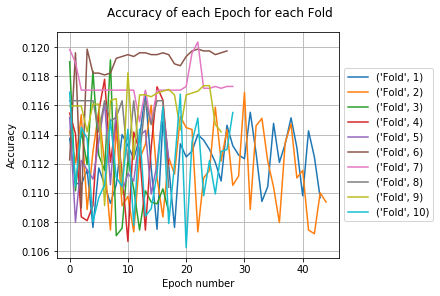

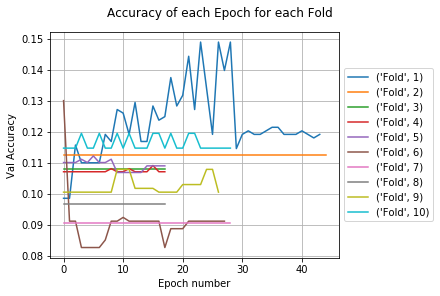

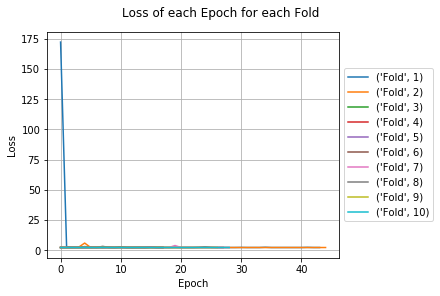

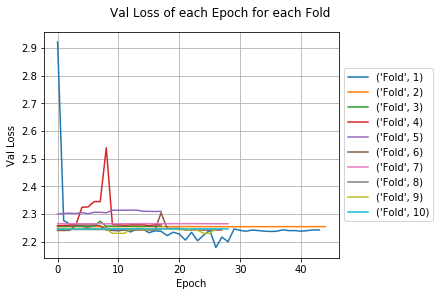

In [38]:
Graph_Epochs_model_3=Graph_func(Epoch_number,Epoch_array_accuracy_3,Val_accuracy_array_3,Loss_array_3,Val_Loss_array_3)

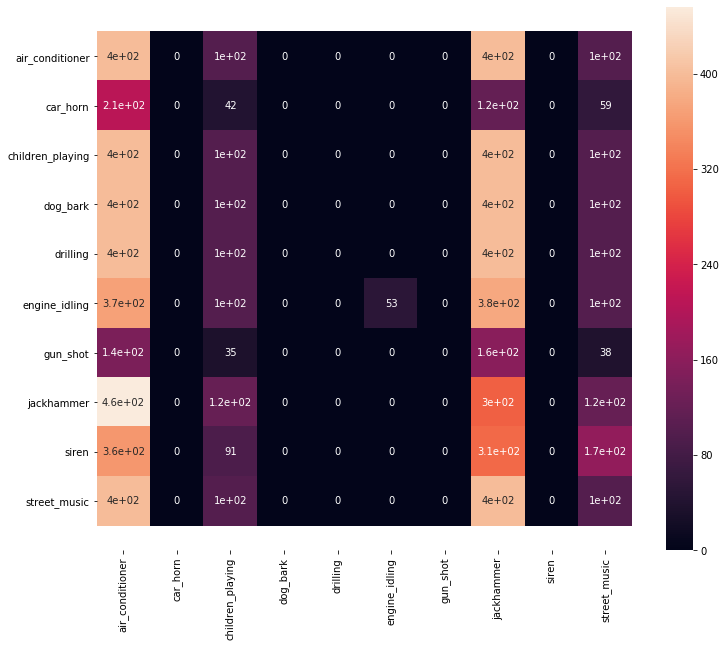

In [39]:
avg_cm = average_confusion_matrix(Confusion_Matrix_array)
plot_confusion_matrix(avg_cm)

In [40]:
Table_model_3=table_maker(Fold_accuracy_3,end_array_3,Avg_Accuracy_3,Time_3)

  Fold  Accuracy  Time Taken
0    1  0.112237    323.0230
1    2  0.111848    304.0262
2    3  0.111645    122.9056
3    4  0.112611    118.9107
4    5  0.112479    115.4230
5    6  0.118680    189.8843
6    7  0.117309    194.9393
7    8  0.115205    125.6533
8    9  0.115664    178.9861
9   10  0.111948    198.5337

    Average Accuracy  Total Time
0          0.113962   1872.2852


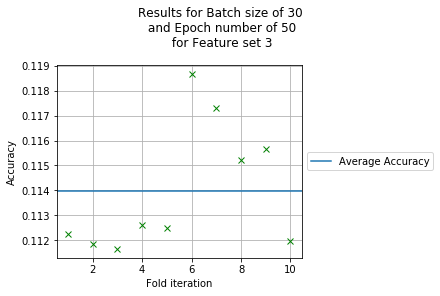

In [41]:
Graph_Avg_model_3=Graph_Avg_maker(Fold_accuracy_3,Avg_Accuracy_3)

### Model 3 no cross validation

In [42]:
X_train = np.vstack([X_folds_10[j] for j in range(0, len(Y_folds_10)-1)])
y_train = np.vstack([Y_folds_10[j] for j in range(0, len(Y_folds_10)-1)])
X_test = X_folds_10[9]
y_test = Y_folds_10[9]

Epoch_number=30
cnn_model_3_history = model_3.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=Epoch_number)
score_model_3_no_cross=model_3.evaluate(X_test, y_test)
accuracy_model_3_no_cross = score_model_3_no_cross[1]
print(f"\nAccuracy of model 3 with no cross validation: {round(accuracy_model_3_no_cross,3)}")

Train on 7895 samples, validate on 837 samples
Epoch 1/30
7895/7895 [==============================] - ETA: 5s - loss: 2.2337 - accuracy: 0.09 - ETA: 6s - loss: 2.2829 - accuracy: 0.10 - ETA: 6s - loss: 2.2720 - accuracy: 0.12 - ETA: 6s - loss: 2.2693 - accuracy: 0.12 - ETA: 6s - loss: 2.2592 - accuracy: 0.13 - ETA: 6s - loss: 2.2503 - accuracy: 0.13 - ETA: 6s - loss: 2.2648 - accuracy: 0.12 - ETA: 6s - loss: 2.2626 - accuracy: 0.11 - ETA: 6s - loss: 2.2626 - accuracy: 0.11 - ETA: 6s - loss: 2.2633 - accuracy: 0.11 - ETA: 6s - loss: 2.2604 - accuracy: 0.11 - ETA: 6s - loss: 2.2601 - accuracy: 0.11 - ETA: 6s - loss: 2.2593 - accuracy: 0.11 - ETA: 6s - loss: 2.2583 - accuracy: 0.10 - ETA: 6s - loss: 2.2573 - accuracy: 0.10 - ETA: 6s - loss: 2.2583 - accuracy: 0.10 - ETA: 6s - loss: 2.2611 - accuracy: 0.10 - ETA: 6s - loss: 2.2642 - accuracy: 0.09 - ETA: 6s - loss: 2.2610 - accuracy: 0.09 - ETA: 6s - loss: 2.2622 - accuracy: 0.09 - ETA: 6s - loss: 2.2638 - accuracy: 0.10 - ETA: 5s - loss:

## Model 4

In [43]:
#adding layers and forming the model_1
#forming model_1
model_4=Sequential()

model_4.add(Conv2D(64,kernel_size=5,strides=1,padding="Same",activation="relu",input_shape=(32,8,1)))
model_4.add(MaxPooling2D(padding="same"))

model_4.add(Flatten())

model_4.add(Dense(10,activation="softmax"))
#compiling
Model_4=model_4.compile(optimizer="adam",loss="categorical_crossentropy",metrics=["accuracy"])

In [44]:
Accuracy_array_4=[]
accuracy_total_4=0
end_array_4=[]

Epoch_array_accuracy_4=[]
Loss_array_4=[]
Fold_accuracy_4=[]

Val_accuracy_array_4=[]
Val_Loss_array_4=[]

Avg_Accuracy_4=[]
Time_4=[]

accuracy_score=[]
Epoch_number=50
Batch_size=30

Confusion_Matrix_array = []
Metrics_f1 = []
Metrics_precision = []
Metrics_recall = []
Metrics_accuracy = []

Model_4=Model_run_nn_es_NO_EARLY_STOPPING(Model_4,model_4,X_folds_10,Y_folds_10,Accuracy_array_4,
                     accuracy_total_4,end_array_4,Epoch_array_accuracy_4,Loss_array_4,
                     Fold_accuracy_4,Val_accuracy_array_4,Val_Loss_array_4, Confusion_Matrix_array,
                     Metrics_f1, Metrics_precision, Metrics_recall, Metrics_accuracy)
Avg_Accuracy_4=Model_4[0]
Time_4=Model_4[1]


Fold #1
- - - - - - - - - - - - - - - - - - - -
(7859, 32, 8, 1) (7859, 10) (873, 32, 8, 1) (873, 10)
Accuracy of Fold 1 is 0.7143402099609375
Time to train Fold 1 : 234.0695 seconds.

Fold #2
- - - - - - - - - - - - - - - - - - - -
(7844, 32, 8, 1) (7844, 10) (888, 32, 8, 1) (888, 10)
Accuracy of Fold 2 is 0.8623635768890381
Time to train Fold 2 : 229.1775 seconds.

Fold #3
- - - - - - - - - - - - - - - - - - - -
(7807, 32, 8, 1) (7807, 10) (925, 32, 8, 1) (925, 10)
Accuracy of Fold 3 is 0.900999128818512
Time to train Fold 3 : 228.5196 seconds.

Fold #4
- - - - - - - - - - - - - - - - - - - -
(7742, 32, 8, 1) (7742, 10) (990, 32, 8, 1) (990, 10)
Accuracy of Fold 4 is 0.9167425036430359
Time to train Fold 4 : 220.4903 seconds.

Fold #5
- - - - - - - - - - - - - - - - - - - -
(7796, 32, 8, 1) (7796, 10) (936, 32, 8, 1) (936, 10)
Accuracy of Fold 5 is 0.9309491515159607
Time to train Fold 5 : 226.6874 seconds.

Fold #6
- - - - - - - - - - - - - - - - - - - -
(7909, 32, 8, 1) (7909, 10)

In [45]:
print('Fold No, F-measure, Precision, Recall, Accuracy')
for i in range(10):
    print(f'{i+1}, {Metrics_f1[i]}, {Metrics_precision[i]}, {Metrics_recall[i]}, {Metrics_accuracy[i]}')
#     print(i + Metrics_f1 + ' , 'Metrics_precision + ' , 'Metrics_recall + ' , 'Metrics_accuracy)

Fold No, F-measure, Precision, Recall, Accuracy
1, 0.5137026406852969, 0.5485234492454882, 0.5315005727376861, 0.5315005727376861
2, 0.6335706868854913, 0.6946068274477456, 0.6463963963963963, 0.6463963963963963
3, 0.6998848100582963, 0.7408439308016157, 0.6972972972972973, 0.6972972972972973
4, 0.765092416341884, 0.8005922745572813, 0.7676767676767676, 0.7676767676767676
5, 0.8051284514030064, 0.8327949684025758, 0.8034188034188035, 0.8034188034188035
6, 0.8129200051860312, 0.8205601669940633, 0.8140947752126367, 0.8140947752126367
7, 0.8734603256529281, 0.8906274900329996, 0.8735083532219571, 0.8735083532219571
8, 0.8043932458068028, 0.8348471752643083, 0.815136476426799, 0.815136476426799
9, 0.8917571152358521, 0.907820359331387, 0.8933823529411765, 0.8933823529411765
10, 0.8909649640715388, 0.9128929138556767, 0.8888888888888888, 0.8888888888888888


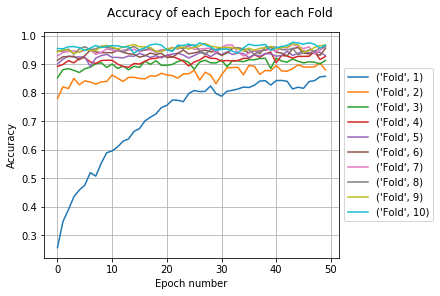

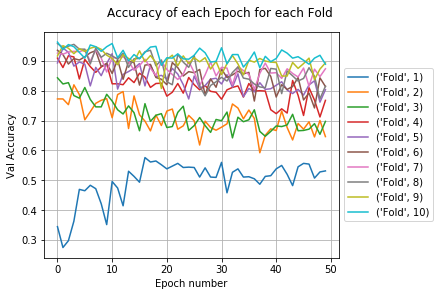

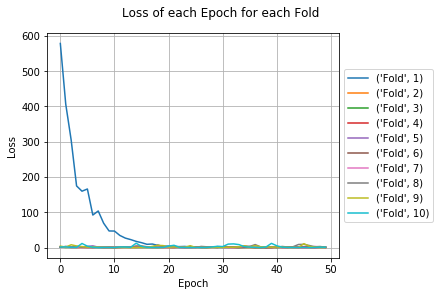

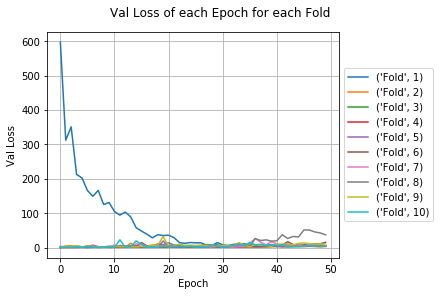

In [46]:
Graph_Epochs_model_4=Graph_func(Epoch_number,Epoch_array_accuracy_4,Val_accuracy_array_4,Loss_array_4,Val_Loss_array_4)

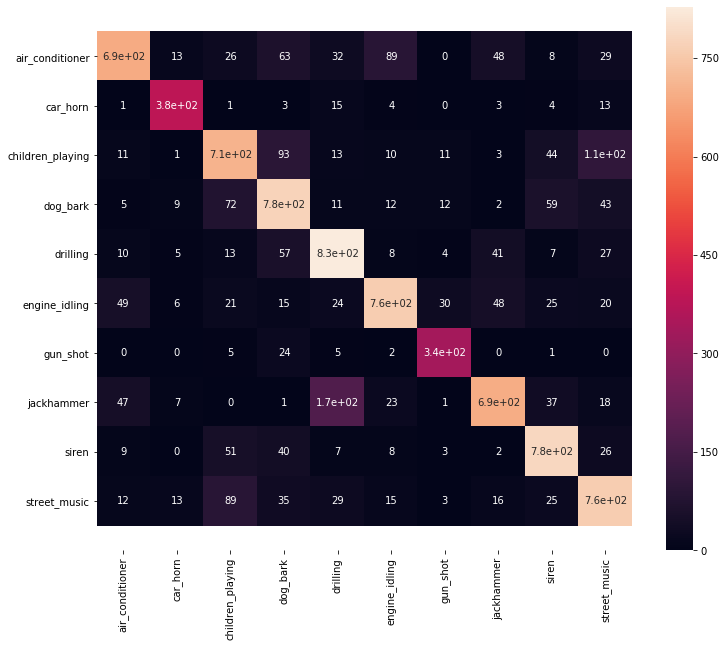

In [47]:
avg_cm = average_confusion_matrix(Confusion_Matrix_array)
plot_confusion_matrix(avg_cm)

In [48]:
Table_model_4=table_maker(Fold_accuracy_4,end_array_4,Avg_Accuracy_4,Time_4)

  Fold  Accuracy  Time Taken
0    1  0.714340    234.0695
1    2  0.862364    229.1775
2    3  0.900999    228.5196
3    4  0.916743    220.4903
4    5  0.930949    226.6874
5    6  0.939911    227.1591
6    7  0.950638    230.2368
7    8  0.952372    239.6429
8    9  0.956908    235.5003
9   10  0.961236    238.6682

    Average Accuracy  Total Time
0          0.908646   2310.1516


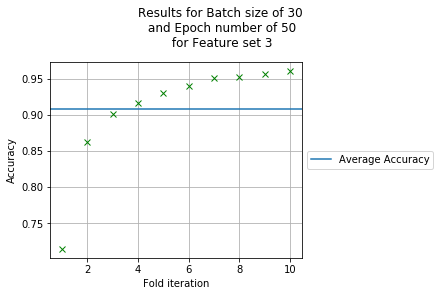

In [49]:
Graph_Avg_model_4=Graph_Avg_maker(Fold_accuracy_4,Avg_Accuracy_4)

In [50]:
X_train = np.vstack([X_folds_10[j] for j in range(0, len(Y_folds_10)-1)])
y_train = np.vstack([Y_folds_10[j] for j in range(0, len(Y_folds_10)-1)])
X_test = X_folds_10[9]
y_test = Y_folds_10[9]

Epoch_number=30
cnn_model_4_history = model_4.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=Epoch_number)
score_model_4_no_cross=model_4.evaluate(X_test, y_test)
accuracy_model_4_no_cross = score_model_4_no_cross[1]
print(f"\nAccuracy of model 4 with no cross validation: {round(accuracy_model_4_no_cross,4)}")

Train on 7895 samples, validate on 837 samples
Epoch 1/30
7895/7895 [==============================] - ETA: 4s - loss: 1.1744e-05 - accuracy: 1.00 - ETA: 4s - loss: 0.8273 - accuracy: 0.9531   - ETA: 4s - loss: 1.2525 - accuracy: 0.94 - ETA: 4s - loss: 0.9311 - accuracy: 0.95 - ETA: 4s - loss: 0.9035 - accuracy: 0.94 - ETA: 4s - loss: 0.8378 - accuracy: 0.95 - ETA: 3s - loss: 0.9997 - accuracy: 0.95 - ETA: 3s - loss: 1.0444 - accuracy: 0.94 - ETA: 3s - loss: 1.1773 - accuracy: 0.94 - ETA: 3s - loss: 1.1055 - accuracy: 0.94 - ETA: 3s - loss: 1.0199 - accuracy: 0.95 - ETA: 3s - loss: 0.9695 - accuracy: 0.95 - ETA: 3s - loss: 0.9102 - accuracy: 0.95 - ETA: 3s - loss: 0.9402 - accuracy: 0.95 - ETA: 3s - loss: 0.8776 - accuracy: 0.95 - ETA: 3s - loss: 0.8416 - accuracy: 0.95 - ETA: 3s - loss: 0.7968 - accuracy: 0.95 - ETA: 3s - loss: 0.8896 - accuracy: 0.95 - ETA: 3s - loss: 0.8900 - accuracy: 0.95 - ETA: 3s - loss: 0.8603 - accuracy: 0.95 - ETA: 3s - loss: 0.8665 - accuracy: 0.95 - ETA: 3s

## Model from Github

In [51]:
# Model from GitHub

#adding layers and forming the model

#forming model
model_5=Sequential()

model_5.add(Conv2D(64,kernel_size=5,strides=1,padding="Same",activation="relu",input_shape=(32,8,1)))
model_5.add(MaxPooling2D(padding="same"))

model_5.add(Conv2D(128,kernel_size=5,strides=1,padding="same",activation="relu"))
model_5.add(MaxPooling2D(padding="same"))
model_5.add(Dropout(0.3))

model_5.add(Flatten())

model_5.add(Dense(256,activation="relu"))
model_5.add(Dropout(0.3))

model_5.add(Dense(512,activation="relu"))
model_5.add(Dropout(0.3))

model_5.add(Dense(10,activation="softmax"))

#compiling
Model_5=model_5.compile(optimizer="adam",loss="categorical_crossentropy",metrics=["accuracy"])

In [52]:
Accuracy_array_5=[]
accuracy_total_5=0
end_array_5=[]

Epoch_array_accuracy_5=[]
Loss_array_5=[]
Fold_accuracy_5=[]

Val_accuracy_array_5=[]
Val_Loss_array_5=[]

Avg_Accuracy_5=[]
Time_5=[]

accuracy_score=[]
Epoch_number=50
Batch_size=30

Confusion_Matrix_array = []
Metrics_f1 = []
Metrics_precision = []
Metrics_recall = []
Metrics_accuracy = []

Model_5=Model_run_nn_es_NO_EARLY_STOPPING(Model_5,model_5,X_folds_10,Y_folds_10,Accuracy_array_5,
                     accuracy_total_5,end_array_5,Epoch_array_accuracy_5,Loss_array_5,
                     Fold_accuracy_5,Val_accuracy_array_5,Val_Loss_array_5, Confusion_Matrix_array,
                     Metrics_f1, Metrics_precision, Metrics_recall, Metrics_accuracy)
Avg_Accuracy_5=Model_5[0]
Time_5=Model_5[1]


Fold #1
- - - - - - - - - - - - - - - - - - - -
(7859, 32, 8, 1) (7859, 10) (873, 32, 8, 1) (873, 10)


C:\Users\tomna\Untitled Folder\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\tomna\Untitled Folder\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Accuracy of Fold 1 is 0.1117139533162117
Time to train Fold 1 : 965.917 seconds.

Fold #2
- - - - - - - - - - - - - - - - - - - -
(7844, 32, 8, 1) (7844, 10) (888, 32, 8, 1) (888, 10)
Accuracy of Fold 2 is 0.11118306964635849
Time to train Fold 2 : 972.0737 seconds.

Fold #3
- - - - - - - - - - - - - - - - - - - -
(7807, 32, 8, 1) (7807, 10) (925, 32, 8, 1) (925, 10)
Accuracy of Fold 3 is 0.11111053824424744
Time to train Fold 3 : 780.3886 seconds.

Fold #4
- - - - - - - - - - - - - - - - - - - -
(7742, 32, 8, 1) (7742, 10) (990, 32, 8, 1) (990, 10)
Accuracy of Fold 4 is 0.11157583445310593
Time to train Fold 4 : 786.7318 seconds.

Fold #5
- - - - - - - - - - - - - - - - - - - -
(7796, 32, 8, 1) (7796, 10) (936, 32, 8, 1) (936, 10)
Accuracy of Fold 5 is 0.10984094440937042
Time to train Fold 5 : 1070.1711 seconds.

Fold #6
- - - - - - - - - - - - - - - - - - - -
(7909, 32, 8, 1) (7909, 10) (823, 32, 8, 1) (823, 10)
Accuracy of Fold 6 is 0.11743076145648956
Time to train Fold 6 : 793.95

In [53]:
print('Fold No, F-measure, Precision, Recall, Accuracy')
for i in range(10):
    print(f'{i+1}, {Metrics_f1[i]}, {Metrics_precision[i]}, {Metrics_recall[i]}, {Metrics_accuracy[i]}')
#     print(i + Metrics_f1 + ' , 'Metrics_precision + ' , 'Metrics_recall + ' , 'Metrics_accuracy)

Fold No, F-measure, Precision, Recall, Accuracy
1, 0.02354522861828357, 0.013121138284988499, 0.1145475372279496, 0.1145475372279496
2, 0.02279607542765438, 0.012681600519438356, 0.11261261261261261, 0.11261261261261261
3, 0.02109426499670402, 0.01168736303871439, 0.10810810810810811, 0.10810810810810811
4, 0.01853396348809193, 0.010203040506070809, 0.10101010101010101, 0.10101010101010101
5, 0.020625020625020623, 0.011414274234787055, 0.10683760683760683, 0.10683760683760683
6, 0.012611602729059193, 0.006826815329035078, 0.08262454434993925, 0.08262454434993925
7, 0.015082278844597171, 0.008225061374678887, 0.09069212410501193, 0.09069212410501193
8, 0.017077798861480076, 0.009365244536940686, 0.0967741935483871, 0.0967741935483871
9, 0.018352329796060964, 0.010098279507881584, 0.10049019607843138, 0.10049019607843138
10, 0.02222222222222222, 0.012345679012345678, 0.1111111111111111, 0.1111111111111111


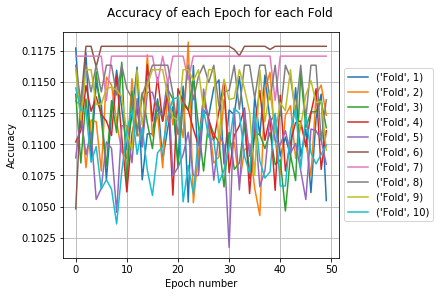

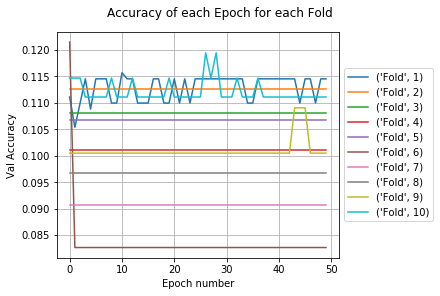

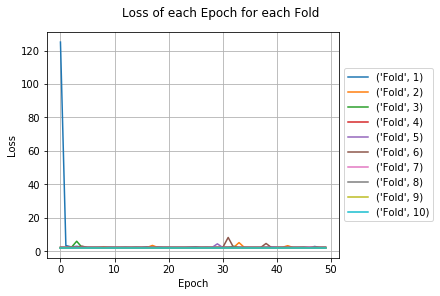

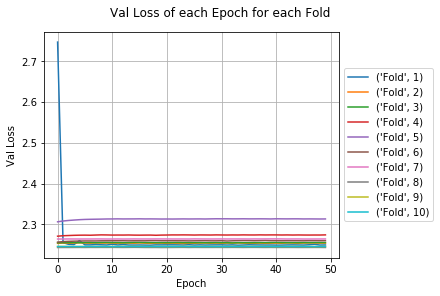

In [54]:
Graph_Epochs_model_5=Graph_func(Epoch_number,Epoch_array_accuracy_5,Val_accuracy_array_5,Loss_array_5,Val_Loss_array_5) 

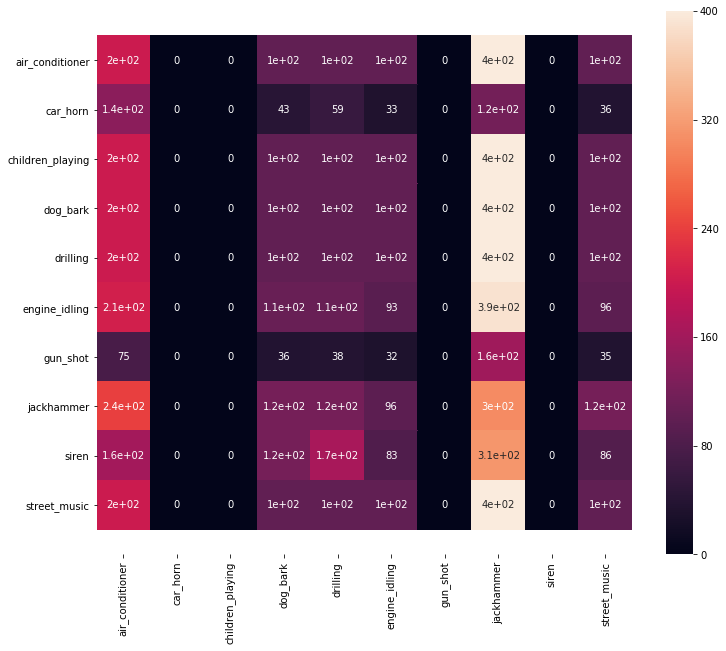

In [55]:
avg_cm = average_confusion_matrix(Confusion_Matrix_array)
plot_confusion_matrix(avg_cm)

In [56]:
Table_model_5=table_maker(Fold_accuracy_5,end_array_5,Avg_Accuracy_5,Time_5)

  Fold  Accuracy  Time Taken
0    1  0.111714    965.9170
1    2  0.111183    972.0737
2    3  0.111111    780.3886
3    4  0.111576    786.7318
4    5  0.109841   1070.1711
5    6  0.117431    793.9522
6    7  0.116785    739.1176
7    8  0.114762    745.6406
8    9  0.113732    788.2745
9   10  0.109614    766.7095

    Average Accuracy  Total Time
0          0.112775   8408.9766


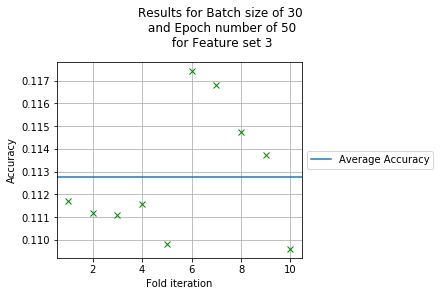

In [57]:
Graph_Avg_model_5=Graph_Avg_maker(Fold_accuracy_5,Avg_Accuracy_5)

### Github model with no cross validation

In [58]:
X_train = np.vstack([X_folds_10[j] for j in range(0, len(Y_folds_10)-1)])
y_train = np.vstack([Y_folds_10[j] for j in range(0, len(Y_folds_10)-1)])
X_test = X_folds_10[9]
y_test = Y_folds_10[9]

Epoch_number=30
cnn_model_5_history = model_5.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=Epoch_number)
score_model_5_no_cross=model_5.evaluate(X_test, y_test)
accuracy_model_5_no_cross = score_model_5_no_cross[1]
print(f"\nAccuracy of model 5 with no cross validation: {round(accuracy_model_5_no_cross,4)}")

Train on 7895 samples, validate on 837 samples
Epoch 1/30
6240/7895 [======================>.......] - ETA: 11s - loss: 2.2297 - accuracy: 0.093 - ETA: 12s - loss: 2.2027 - accuracy: 0.125 - ETA: 12s - loss: 2.2054 - accuracy: 0.104 - ETA: 12s - loss: 2.2173 - accuracy: 0.117 - ETA: 12s - loss: 2.2446 - accuracy: 0.100 - ETA: 12s - loss: 2.2647 - accuracy: 0.104 - ETA: 13s - loss: 2.2603 - accuracy: 0.111 - ETA: 13s - loss: 2.2563 - accuracy: 0.113 - ETA: 12s - loss: 2.2608 - accuracy: 0.111 - ETA: 12s - loss: 2.2633 - accuracy: 0.110 - ETA: 12s - loss: 2.2675 - accuracy: 0.112 - ETA: 12s - loss: 2.2671 - accuracy: 0.117 - ETA: 12s - loss: 2.2644 - accuracy: 0.122 - ETA: 12s - loss: 2.2623 - accuracy: 0.120 - ETA: 12s - loss: 2.2584 - accuracy: 0.113 - ETA: 12s - loss: 2.2605 - accuracy: 0.114 - ETA: 12s - loss: 2.2601 - accuracy: 0.112 - ETA: 12s - loss: 2.2585 - accuracy: 0.113 - ETA: 12s - loss: 2.2599 - accuracy: 0.112 - ETA: 12s - loss: 2.2625 - accuracy: 0.111 - ETA: 12s - loss: 

### Model comparisson

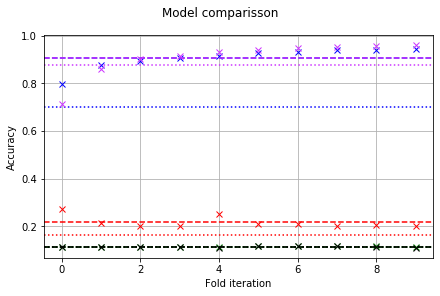

In [62]:


%matplotlib inline

 

fig, ax1 = plt.subplots(1, 1, constrained_layout=True, subplot_kw=dict())

 

ax1.plot(Fold_accuracy,"rx",label="Model 1")
ax1.axhline(y=Avg_Accuracy,label='Average Accuracy Model 1',color='r',ls="--")
ax1.axhline(y=accuracy_model_1_no_cross,label='Accuracy Model 1 no cross validation',color='r',ls=":")

 


ax1.plot(Fold_accuracy_2,"bx",label="Model 2")
ax1.axhline(y=Avg_Accuracy_2,label='Average Accuracy Model 2',color='b',ls="--")
ax1.axhline(y=accuracy_model_2_no_cross,label='Accuracy Model 2 no cross validation',color='b',ls=":")

 


ax1.plot(Fold_accuracy_3,"gx",label="Model 3")
ax1.axhline(y=Avg_Accuracy_3,label='Average Accuracy Model 3',color='g',ls="--")
ax1.axhline(y=accuracy_model_3_no_cross,label='Accuracy Model 3 no cross validation',color='g',ls=":")

 

ax1.plot(Fold_accuracy_4,"x", color="#cc33ff",label="Model 4")
ax1.axhline(y=Avg_Accuracy_4,label='Average Accuracy Model 4',color='#cc33ff',ls="--")
ax1.axhline(y=accuracy_model_4_no_cross,label='Accuracy Model 4 no cross validation',color='#cc33ff',ls=":")

 

ax1.plot(Fold_accuracy_5,"kx",label="Model 5")
ax1.axhline(y=Avg_Accuracy_5,label='Average Accuracy Model 5',color='k',ls="--")
ax1.axhline(y=accuracy_model_5_no_cross,label='Accuracy Model 5 no cross validation',color='k',ls=":")

 

#ax1.set_title('Results for a batch size of',Batch_size,'and',Epoch_number,'.')
fig.suptitle(f"Model comparisson")
ax1.set_xlabel("Fold iteration")
ax1.set_ylabel("Accuracy")
ax1.grid()
#ax1.legend(loc='center left', bbox_to_anchor=(1, 0.5))

## Logistic Regression

In [60]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

X_folds, Y_folds = data_processor_log_reg(X_folds,Y_folds)

X_train = np.vstack([X_folds[j] for j in range(0, len(Y_folds)-1)])
y_train = np.vstack([Y_folds[j] for j in range(0, len(Y_folds)-1)])
X_test = X_folds[9]
y_test = Y_folds[9]

logreg = LogisticRegression()
logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

C:\Users\tomna\Untitled Folder\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\tomna\Untitled Folder\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\tomna\Untitled Folder\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\tomna\Untitled Folder\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Accuracy of logistic regression classifier on test set: 0.44


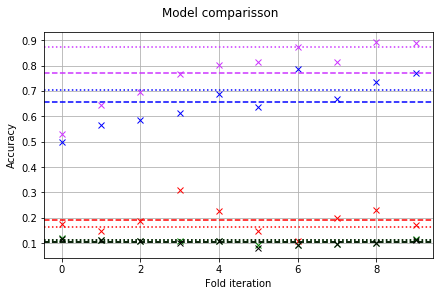

In [65]:
Val_accuracy_array_fix = [Val_accuracy_array[i][-1] for i in range(10)]
Val_accuracy_array_2_fix = [Val_accuracy_array_2[i][-1] for i in range(10)]
Val_accuracy_array_3_fix = [Val_accuracy_array_3[i][-1] for i in range(10)]
Val_accuracy_array_4_fix = [Val_accuracy_array_4[i][-1] for i in range(10)]
Val_accuracy_array_5_fix = [Val_accuracy_array_5[i][-1] for i in range(10)]

 

%matplotlib inline

 

fig, ax1 = plt.subplots(1, 1, constrained_layout=True, subplot_kw=dict())

 

ax1.plot(Val_accuracy_array_fix,"rx",label="Model 1")
ax1.axhline(y=np.average(Val_accuracy_array_fix),label='Average Accuracy Model 1',color='r',ls="--")
ax1.axhline(y=accuracy_model_1_no_cross,label='Accuracy Model 1 no cross validation',color='r',ls=":")

 


ax1.plot(Val_accuracy_array_2_fix,"bx",label="Model 2")
ax1.axhline(y=np.average(Val_accuracy_array_2_fix),label='Average Accuracy Model 2',color='b',ls="--")
ax1.axhline(y=accuracy_model_2_no_cross,label='Accuracy Model 2 no cross validation',color='b',ls=":")

 


ax1.plot(Val_accuracy_array_3_fix,"gx",label="Model 3")
ax1.axhline(y=np.average(Val_accuracy_array_3_fix),label='Average Accuracy Model 3',color='g',ls="--")
ax1.axhline(y=accuracy_model_3_no_cross,label='Accuracy Model 3 no cross validation',color='g',ls=":")

 

ax1.plot(Val_accuracy_array_4_fix,"x", color="#cc33ff",label="Model 4")
ax1.axhline(y=np.average(Val_accuracy_array_4_fix),label='Average Accuracy Model 4',color='#cc33ff',ls="--")
ax1.axhline(y=accuracy_model_4_no_cross,label='Accuracy Model 4 no cross validation',color='#cc33ff',ls=":")

 

ax1.plot(Val_accuracy_array_5_fix,"kx",label="Model 5")
ax1.axhline(y=np.average(Val_accuracy_array_5_fix),label='Average Accuracy Model 5',color='k',ls="--")
ax1.axhline(y=accuracy_model_5_no_cross,label='Accuracy Model 5 no cross validation',color='k',ls=":")

 

#ax1.set_title('Results for a batch size of',Batch_size,'and',Epoch_number,'.')
fig.suptitle(f"Model comparisson")
ax1.set_xlabel("Fold iteration")
ax1.set_ylabel("Accuracy")
ax1.grid()

#ax1.legend(loc='center left', bbox_to_anchor=(1, 0.5))